<h1><center>An Agent-based Economy Model</center></h1>

## Running the Agent-based Model

<span style="color:darkorange">Set the SDK path and maven repository path here.</span>

In [1]:
import json
from IPython.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))
with open('notebook_settings.json', 'r') as f:
    notebook_settings = json.load(f)

In [2]:
# Example of sector data
sector_data = {
    'E36': {
         'I': 319, 'N': 1860, 'alpha':0.0988, 'beta': 2.5567, 'kappa': 0.0399, 'delta': 0.0095, 'w': 0.0134,
        'tauY': 0.0071, 'tauK': 0.0266, 'bCF_g': 0, 'bCFH_g': 0, 'bHH_g': .001, 'cG_g': 0, 'cE_g': 0, 'cI_g': 0
    }
}

In [3]:
import os

from utils import *

level = 'WARN'
params = {
    'vm': {'seed': 123, 'runs': 1, 'ticks': 3, 
           'level': level, 'levelHH': level, 'levelFirm': level, 'levelEconomy': level},
    'config': {'simudyne.core.export-path': 'Output_{0}'.format(123)},
    'input': {'G': 2, 'I': 100, 'H': 1000, 'alpha': .005, 'w': .2, 'kappa': .03, 'delta': 0.01,
              'wh0': 40., 'C_h_d0': 10.0, 'beta': 1.5, 'bCF_g': 0.0, 'bCFH_g': 0.0, 'bHH_g': 0.0092, 
              'cG_g': 0, 'cE_g': 0, 'cI_g': 0, 'a_s_g': .1, 'pi': .01},
    'notebook_settings' : notebook_settings
}

In [4]:
from joblib import Parallel, delayed
from tqdm import trange

np.random.seed(1234)
variable = 'bCFH_g'
_n = 3
_seeds = np.random.randint(0, 10000000, _n)
X_ = np.linspace(.001, .01, _n, dtype=float).round(6).reshape([-1,1])
res_ = Parallel(n_jobs=6, verbose=8)(delayed(get_sim)({variable: X_[i][0]}, params, i=i, seed=_seeds[i]) 
                                     for i in np.arange(len(X_)))

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed:   12.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed:   12.0s finished


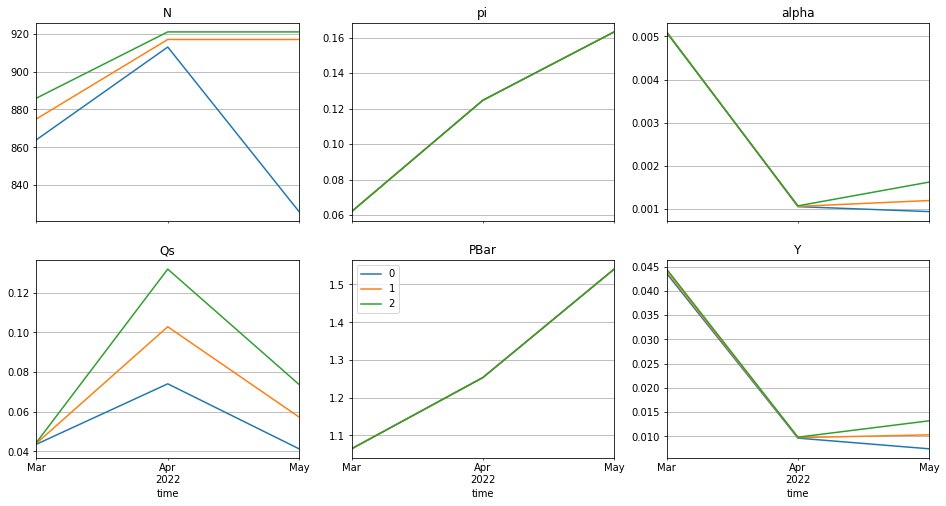

In [5]:
plot_res(res_)

# <span style="color:blue">Calibration using Surrogate Modelling</span>

##### Using the package 'skopt'

## Historical Data

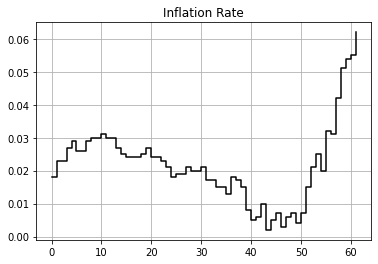

In [6]:
inflation_rate = pd.read_csv('/Users/perukrishnenvytelingum/GitHub/ClimateRiskABM-V1/data/cpi.csv', 
                             header=None).loc[0].iloc[:-1]
inflation_rate.plot(color='k', grid=True, title='Inflation Rate', drawstyle='steps-post')
cal = inflation_rate.diff().agg([np.mean, np.std])
historical_data = {'inflation_rate': cal}

In [7]:
%%time

f(np.array([0.4, 1]), ['alpha', 'w'], params, f_error=get_error_ir, mc=3, historical_data=historical_data)

CPU times: user 111 ms, sys: 10.7 ms, total: 122 ms
Wall time: 12.7 s


7956.755609185302

In [8]:
%%time

f(np.array([0.0052, .1]), ['alpha', 'w'], params, f_error=get_error_ir, historical_data=historical_data)

CPU times: user 539 ms, sys: 28.6 ms, total: 568 ms
Wall time: 4.26 s


7111.279182265991

In [9]:
from utils import _f

_f(np.array([0.005]), ['alpha'], params, f_error=get_error_ir, mc=1, historical_data=historical_data)

1201.3968222129392

## Run Surrogate Modelling

In [10]:
%%time

import warnings

from skopt import gp_minimize
from skopt.plots import plot_gaussian_process

mc = 1
bounds = {'alpha': (0.001, 0.009)}
variables = ['alpha']

np.random.seed(1234)

_bounds = [bounds[k] for k in variables]
obj_fn = lambda x: f(x, variables, params, f_error=get_error_ir, mc=mc, historical_data=historical_data)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    res = gp_minimize(obj_fn,             # the function to minimize
                      _bounds,            # the bounds on each dimension of x
                      acq_func="EI",      # the acquisition function
                      n_calls=10,         # the number of evaluations of f
                      n_jobs=6,
                      n_random_starts=2,  # the number of random initialization points
                      noise=.1,          # the noise level (optional)
                      random_state=1234)  # the random seed

CPU times: user 8.48 s, sys: 1.19 s, total: 9.67 s
Wall time: 58.6 s


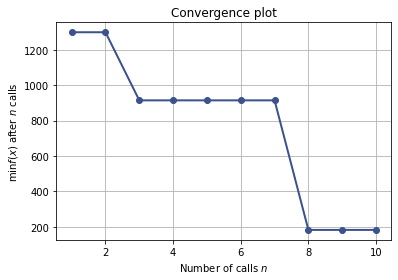

In [11]:
from skopt.plots import plot_convergence

_ = plot_convergence(res)

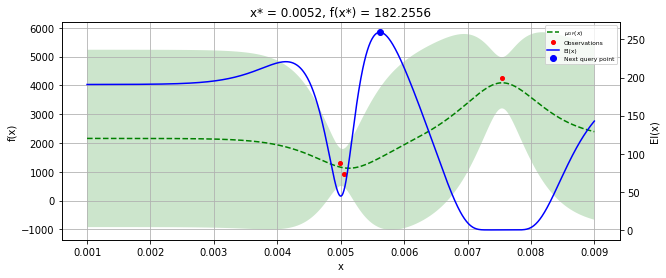

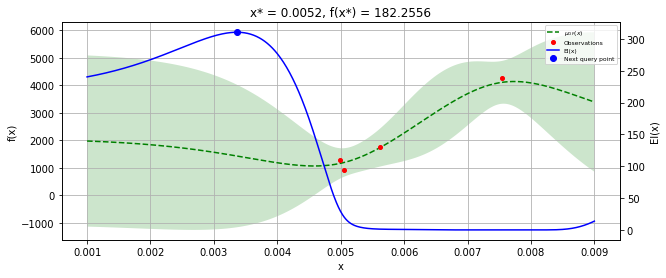

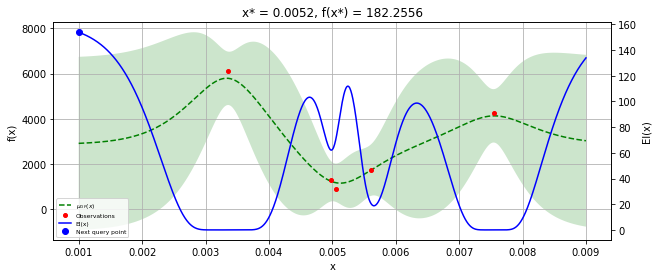

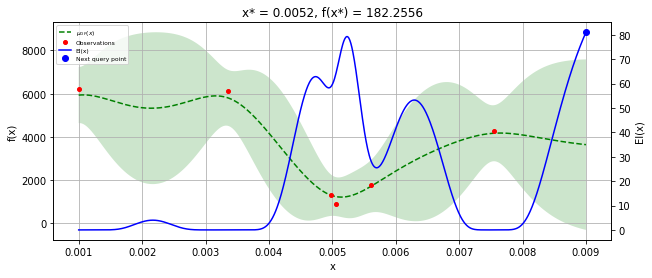

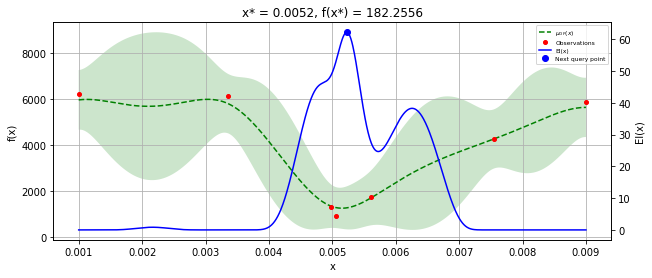

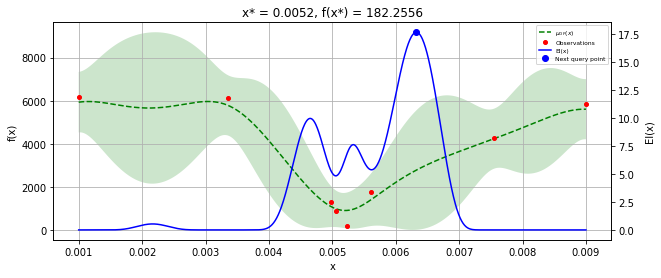

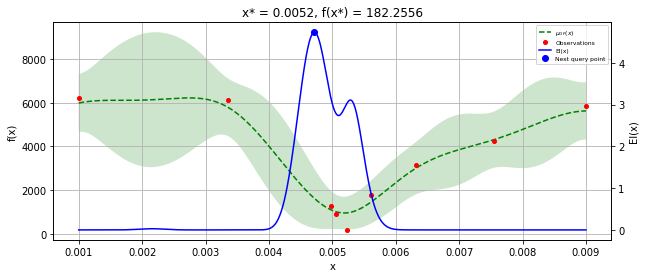

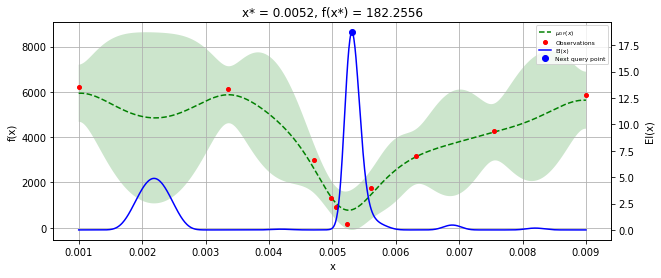

In [12]:
for i in np.arange(1, 9):
    fg, ax = plt.subplots(1, 1, figsize=(10, 4))
    plot_gaussian_process(res, ax=ax, n_calls=i, objective=None, noise_level=1e-6, show_legend=True, 
                               show_title=True, show_next_point=True, show_acq_func=True)
    ax.set_yscale('linear')
    plt.show()